In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

In [ ]:
file_path = '/kaggle/input/credit-risk-benchmark-dataset/Credit Risk Benchmark Dataset.csv'
df = pd.read_csv('/content/Credit Risk Benchmark Dataset.csv')
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
df['default'] = (df['dlq_2yrs'] > 0).astype(int)

display(df.head(10))

variables = {
    'rev_util':    'Credit line utilization compared to available total (0 to 1)',
    'age':         'Customer age',
    'late_30_59':  'Number of times 30–59 days late',
    'debt_ratio':  'Total debt to monthly income ratio',
    'monthly_inc': 'Declared monthly income (log1p applied)',
    'open_credit': 'Number of open credit lines and loans',
    'late_90':     'Number of times over 90 days late',
    'real_estate': 'Number of real estate loans',
    'late_60_89':  'Number of times 60–89 days late',
    'dependents':  'Declared number of dependents',
    'dlq_2yrs':    'Number of delinquencies in the past 2 years',
    'default':     'Binary default flag (1 = default, 0 = no default)'
}
var_desc = (
    pd.DataFrame.from_dict(variables, orient='index', columns=['Description'])
      .reset_index()
      .rename(columns={'index':'Variable'})
)
display(var_desc)


,rev_util,age,late_30_59,debt_ratio,monthly_inc,open_credit,late_90,real_estate,late_60_89,dependents,dlq_2yrs,default
0,0.006999,38.0,0.0,0.302150,5440.0,4.0,0.0,1.0,0.0,3.0,0,0
1,0.704592,63.0,0.0,0.471441,8000.0,9.0,0.0,1.0,0.0,0.0,0,0
2,0.063113,57.0,0.0,0.068586,5000.0,17.0,0.0,0.0,0.0,0.0,0,0
3,0.368397,68.0,0.0,0.296273,6250.0,16.0,0.0,2.0,0.0,0.0,0,0
4,1.000000,34.0,1.0,0.000000,3500.0,0.0,0.0,0.0,0.0,1.0,0,0
5,0.051799,63.0,0.0,0.770687,4700.0,16.0,0.0,1.0,0.0,1.0,0,0
6,0.648733,40.0,1.0,0.402060,6600.0,10.0,0.0,2.0,0.0,3.0,0,0
7,0.767270,33.0,0.0,0.338390,5800.0,10.0,0.0,0.0,0.0,3.0,0,0
8,0.190111,27.0,0.0,0.164605,3960.0,6.0,0.0,0.0,0.0,1.0,0,0
9,0.139989,65.0,1.0,0.258397,6400.0,6.0,0.0,1.0,0.0,0.0,0,0


,Variable,Description
0,rev_util,Credit line utilization compared to available ...
1,age,Customer age
2,late_30_59,Number of times 30–59 days late
3,debt_ratio,Total debt to monthly income ratio
4,monthly_inc,Declared monthly income (log1p applied)
5,open_credit,Number of open credit lines and loans
6,late_90,Number of times over 90 days late
7,real_estate,Number of real estate loans
8,late_60_89,Number of times 60–89 days late
9,dependents,Declared number of dependents


Purpose: Applies log transformation to income for normalization and splits features (X) and target (y)

In [ ]:
df['monthly_inc'] = np.log1p(df['monthly_inc'])
X = df.drop(columns=['dlq_2yrs', 'default'])
y = df['default']

Purpose: Visualizes feature correlation to identify multicollinearity or strong relationships.

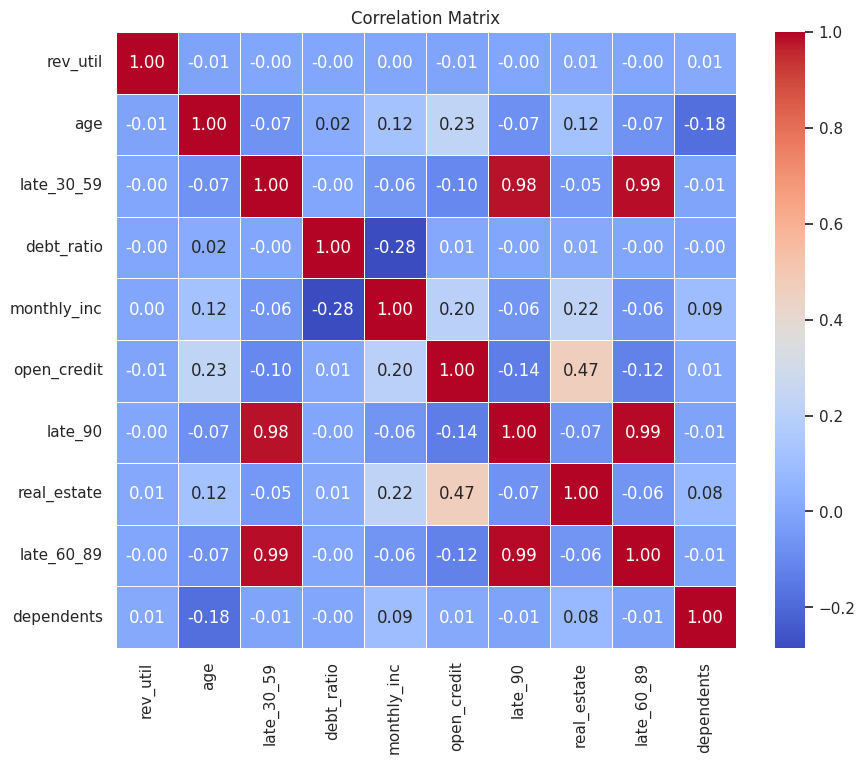

In [ ]:
plt.figure(figsize=(10,8))
corr = X.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

Purpose: Plots the distribution of income with respect to default status.

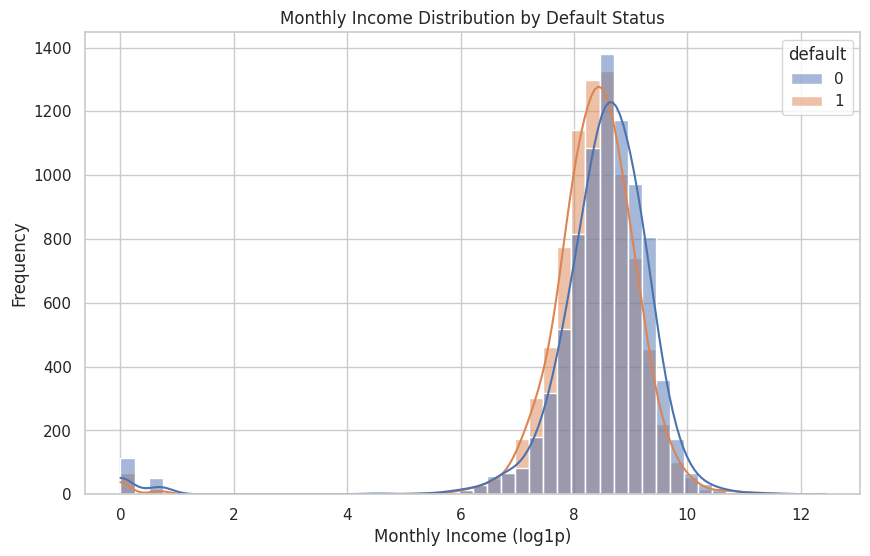

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='monthly_inc', hue='default', bins=50, kde=True)
plt.title('Monthly Income Distribution by Default Status')
plt.xlabel('Monthly Income (log1p)')
plt.ylabel('Frequency')
plt.show()

Purpose: Compares debt ratios between defaulters and non-defaulters.

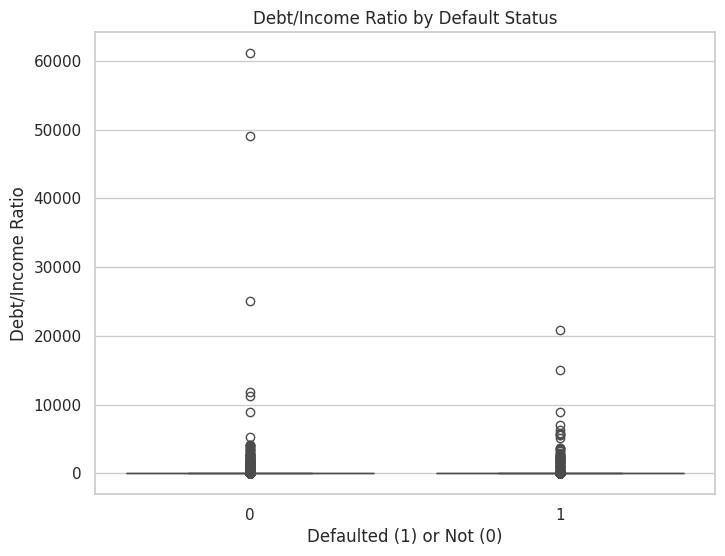

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='default', y='debt_ratio', data=df)
plt.title('Debt/Income Ratio by Default Status')
plt.xlabel('Defaulted (1) or Not (0)')
plt.ylabel('Debt/Income Ratio')
plt.show()

Purpose: Groups age ranges and shows default counts per group.

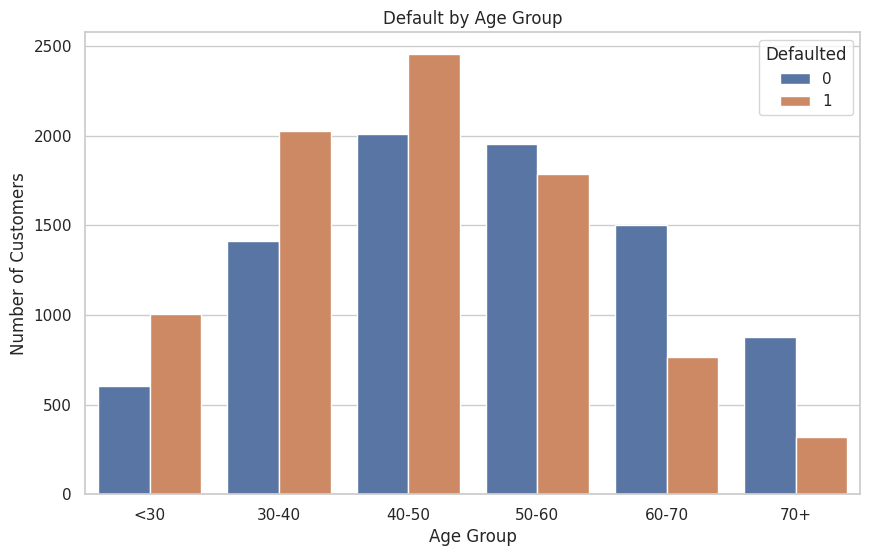

In [ ]:
df['age_group'] = pd.cut(df['age'], bins=[0, 30, 40, 50, 60, 70, 100],
                         labels=['<30', '30-40', '40-50', '50-60', '60-70', '70+'])

plt.figure(figsize=(10, 6))
sns.countplot(x='age_group', hue='default', data=df)
plt.title('Default by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Number of Customers')
plt.legend(title='Defaulted')
plt.show()

Purpose: Splits data for model training/testing and applies feature scaling

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Purpose: Constructs and compiles a feedforward neural network for binary classification.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

# Build the model
model = Sequential([
    Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['AUC']
)

Purpose:Prevents overfitting by stopping training early if no improvement.

In [ ]:
# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

Purpose: Trains the neural network on the training data.

In [ ]:
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 0.6073 - loss: 0.6767 - val_AUC: 0.7488 - val_loss: 0.6138
Epoch 2/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7148 - loss: 0.6282 - val_AUC: 0.7999 - val_loss: 0.5610
Epoch 3/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7604 - loss: 0.5976 - val_AUC: 0.8191 - val_loss: 0.5335
Epoch 4/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7787 - loss: 0.5628 - val_AUC: 0.8237 - val_loss: 0.5239
Epoch 5/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7808 - loss: 0.5629 - val_AUC: 0.8225 - val_loss: 0.5161
Epoch 6/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8002 - loss: 0.5439 - val_AUC: 0.8239 - val_loss: 0.5184
Epoch 7/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7948 - loss: 0.5416 - val_AUC: 0.8251 - val_loss: 0.5136
Epoch 8/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7961 - loss: 0.5428 - val_AUC: 0.8273 - val_loss: 0.5100
Epoch 9/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms

In [ ]:
# Predict probabilities and classes
y_prob_nn = model.predict(X_test_scaled).ravel()
y_pred_nn = (y_prob_nn > 0.5).astype(int)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [ ]:
# Classification report
print("\n--- Neural Network ---")
print(classification_report(y_test, y_pred_nn, digits=4))


--- Neural Network ---
              precision    recall  f1-score   support

           0     0.7274    0.8214    0.7715      2508
           1     0.7948    0.6921    0.7399      2507

    accuracy                         0.7567      5015
   macro avg     0.7611    0.7567    0.7557      5015
weighted avg     0.7611    0.7567    0.7557      5015



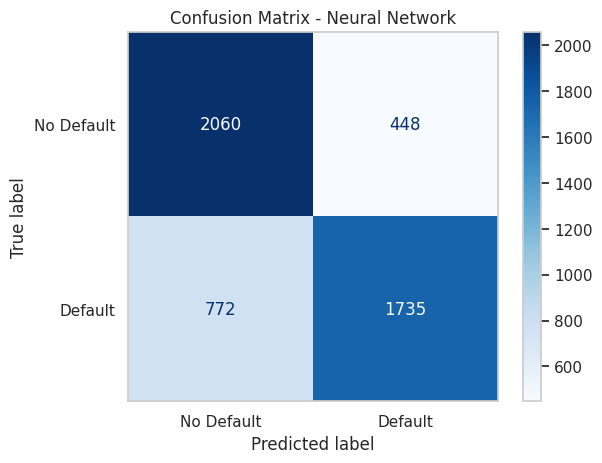

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_nn)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Default', 'Default'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Neural Network')
plt.grid(False)
plt.show()


In [ ]:
# ROC-AUC Score
auc_nn = roc_auc_score(y_test, y_prob_nn)
print(f"AUC Score: {auc_nn:.4f}")

AUC Score: 0.8271


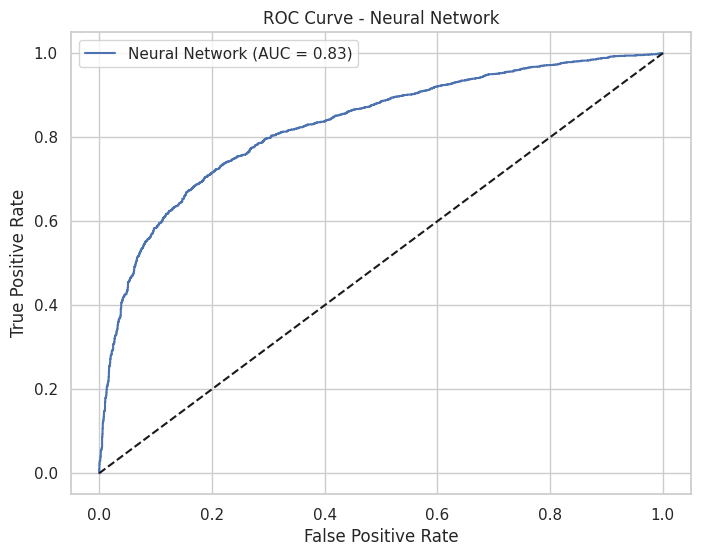

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_prob_nn)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"Neural Network (AUC = {auc_nn:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Neural Network')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = (accuracy_score(y_test, y_pred_nn)*100)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 75.6730
